# BASIC CONFIGURATIONS

In [1]:
### Setup the library ###
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import datetime
import numpy as np
import math
import pprint
import inspect 
top_level=f'{os.getcwd()}/../'
rootTopLevel = top_level+'script/'
pr.addLibraryPath( rootTopLevel )

import setupLibPaths

import ePix320kM as devBoard

args = None

In [2]:
# ONLY RUN ONCE!
# Defining root
# if Jupyter Kernel crashes make sure your dev is correct!!
root =  devBoard.Root(   
        top_level  = rootTopLevel,
        dev        = '/dev/datadev_1',
        pollEn     = False,
        initRead   = True,
        serverPort = 9099)
root.start()

# example showing a read
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

{'name': 'ScopeData0'}
{'name': 'ScopeData1'}
{'name': 'ScopeData2'}
{'name': 'ScopeData3'}
Root.Core.Si5345Pll.Page0.DataBlock.setPollInterval(1)
Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)
Root.Core.AxiVersion count reset called
###################################################
#             Firmware Version                    #
###################################################
Path         = Root.Core.AxiVersion
FwVersion    = 0x1000300
UpTime       = 2:13:52
GitHash      = 0x9550c2a95f7e334393e52bfde914e26fb20f11b8
XilinxDnaId  = 0x400200000139d7204c81a145
FwTarget     = ePixHRM320k
BuildEnv     = Vivado v2023.1
BuildServer  = rdsrv314 (Ubuntu 20.04.6 LTS)
BuildDate    = Wed 17 Jan 2024 11:42:17 PM PST
Builder      = dnajjar
###################################################


In [3]:
# Useful short names
APP  = root.App
AXIV = root.Core.AxiVersion
ASICTOP = APP.AsicTop
TRIG = ASICTOP.TriggerRegisters
ASIC0 = APP.Mv2Asic[0]
ASIC1 = APP.Mv2Asic[1]
ASIC2 = APP.Mv2Asic[2]
ASIC3 = APP.Mv2Asic[3]
HSDAC = APP.Dac.FastDac 
PKREG0 = ASICTOP.DigAsicStrmRegisters0
PKREG1 = ASICTOP.DigAsicStrmRegisters1
PKREG2 = ASICTOP.DigAsicStrmRegisters2
PKREG3 = ASICTOP.DigAsicStrmRegisters3
BATCHER0 = ASICTOP.BatcherEventBuilder0
BATCHER1 = ASICTOP.BatcherEventBuilder1
BATCHER2 = ASICTOP.BatcherEventBuilder2
BATCHER3 = ASICTOP.BatcherEventBuilder3
DEBUG0 = root._dbg[0]
DEBUG1 = root._dbg[1]
DEBUG2 = root._dbg[2]
DEBUG3 = root._dbg[3]
DATARCV0 = root.DataReceiver0
DATARCV1 = root.DataReceiver1
DATARCV2 = root.DataReceiver2
DATARCV3 = root.DataReceiver3
FULLRATERCV0 = root.fullRateDataReceiver[0]
FULLRATERCV1 = root.fullRateDataReceiver[1]
FULLRATERCV2 = root.fullRateDataReceiver[2]
FULLRATERCV3 = root.fullRateDataReceiver[3]
DAC = APP.Dac
REGCTRL = ASICTOP.RegisterControlDualClock

In [4]:
# Set & Read ScratchPad
print(hex(AXIV.ScratchPad.get()))
AXIV.ScratchPad.set(0xdeadbeef)
print(hex(AXIV.ScratchPad.get()))

0xdeadbeef
0xdeadbeef


In [5]:
# Configure clock to 168 MHz and configures all ASICS
root.InitASIC([4,1,1,1,1])

Rysync ASIC started
Init ASIC script started
Loading PLL configuration
Loading supply configuration
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_PowerSupply_Enable.yml
Loading lane delay configurations
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_SspMonGrp_carrier3.yml
Loading waveforms configuration
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_RegisterControl.yml
Loading packet register configurations
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_PacketRegisters.yml
Loading batcher configurations
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../sc

# Helper functions

In [6]:
def enableAllAsics(enable) :
    BATCHER0.Blowoff.set(not enable)
    BATCHER1.Blowoff.set(not enable)
    BATCHER2.Blowoff.set(not enable)
    BATCHER3.Blowoff.set(not enable)
    
def enableAsic(batcherIndex, enable) :
    getattr(root.App.AsicTop, f"BatcherEventBuilder{batcherIndex}").Blowoff.set(not enable)    
    
# Helper functions

def disableAndCleanAllFullRateDataRcv() :
    FULLRATERCV0.cleanData()
    FULLRATERCV1.cleanData()
    FULLRATERCV2.cleanData()
    FULLRATERCV3.cleanData()
    FULLRATERCV0.RxEnable.set(False)
    FULLRATERCV1.RxEnable.set(False)
    FULLRATERCV2.RxEnable.set(False)
    FULLRATERCV3.RxEnable.set(False)

def enableFullRateDataRcv(index, enable) :
    getattr(root, f"fullRateDataReceiver[{index}]").RxEnable.set(enable)
    
    
def enableDataRcv(enable) :
    DATARCV0.RxEnable.set(enable)
    DATARCV1.RxEnable.set(enable)
    DATARCV2.RxEnable.set(enable)
    DATARCV3.RxEnable.set(enable)

def enableFullRateDataRcv(index, enable) :
    getattr(root, f"fullRateDataReceiver[{index}]").RxEnable.set(enable)    

In [7]:
def hwTrigger(frames, rate) :
    # precaution in case someone stops the acquire function in the middle
    TRIG.StopTriggers() 
    
    TRIG.AcqCountReset()
    TRIG.SetAutoTrigger(rate)
    TRIG.numberTrigger.set(frames)
    TRIG.StartAutoTrigger()
    
    # Wait for the file write to write the 10 waveforms
    while (TRIG.AcqCount.get() != frames) :
        print("Triggers sent: {}".format(TRIG.AcqCount.get()) , end='\r')
        time.sleep(0.1)
    print("Triggers sent: {}".format(TRIG.AcqCount.get()))
    
    # stops triggers
    TRIG.StopTriggers()  

In [8]:
def getLaneLocks() :
    for asicIndex in range(4) : 
        root.App.SspMonGrp[asicIndex].enable.set(True)
        print("ASIC{}: {:#x}".format(asicIndex, root.App.SspMonGrp[asicIndex].Locked.get()))

In [9]:
#check current frames in receivers
def printDataReceiverStatus() :
    for asicIndex in range(4):
        print("Checkpoint: DataReceiver {} has {} frames".format(asicIndex, getattr(root, f"DataReceiver{asicIndex}").FrameCount.get()))

# Timing Waveforms

In [10]:
# helper functions
# clock speed is 168MHz. 1 tick is 0.006 us
def setSR0(width, delay) :
    REGCTRL.SR0Delay1.set(delay)
    REGCTRL.SR0Width1.set(width)
    print(f'SR0 Width set to {REGCTRL.SR0Width1_us.get():.3f}uS')
    print(f'SR0 Delay set to {REGCTRL.SR0Delay_us.get():.3f}uS')
    
def setAcq1(width, delay) :
    REGCTRL.AcqDelay1.set(delay)
    REGCTRL.AcqWidth1.set(width)
    print(f'Acq1 Width set to {REGCTRL.AcqWidth1_us.get():.3f}uS')
    print(f'Acq1 Delay set to {REGCTRL.AcqDelay1_us.get():.3f}uS')
    
def setAcq2(width, delay) :
    REGCTRL.AcqDelay2.set(delay)
    REGCTRL.AcqWidth2.set(width)
    print(f'Acq2 Width set to {REGCTRL.AcqWidth2_us.get():.3f}uS')
    print(f'Acq2 Delay set to {REGCTRL.AcqDelay2_us.get():.3f}uS')    

def setR0(width, delay) :
    REGCTRL.R0Delay.set(delay)
    REGCTRL.R0Width.set(width)
    print(f'R0 Width set to {REGCTRL.R0Width_us.get():.3f}uS')
    print(f'R0 Delay set to {REGCTRL.R0Delay_us.get():.3f}uS') 

    
def setSync(width, delay) :
    REGCTRL.SyncDelay.set(delay)
    REGCTRL.SyncWidth.set(width)
    print(f'Sync Delay set to {REGCTRL.SyncDelay_us.get():.3f}uS')     

In [44]:
# Width = 5
# Delay = 10
# setSR0(Width, Delay)
# setAcq1(Width, Delay)
# setAcq2(Width, Delay)
# setR0(Width, Delay)
# setSync(Width, Delay)

# Disable full rate receivers for now

In [ ]:
root.disableAndCleanAllFullRateDataRcv()
root.enableDataRcv(False)
root.enableAllAsics(False)
root.enableAsic(2, True)
DEBUG2.enableDataDebug(True)
DEBUG2.cleanData()

# Lorenzo - Helper functions

In [26]:
%run dataProcFunctions.ipynb     #this is were my function was stored

# ADC Response with external DAC single writes

In [ ]:
ASIC2.mTest.set(True)  # Enable external DAC
ASIC2.DHg.set(True)    # Set High gain
ASIC2.S2D_1_b.set(0)   # Set bias current to max (min value)
ASIC2.Ref_gen_d.set(2) # Set 'common-mode' voltage of S/H stage
ASIC2.RefGenB.set(2)   # Don't touch

In [20]:
# Set minimum and maximum values for DAC scan

DAC_minValue=0
DAC_maxValue=548575
DAC_step=10000
DAC_framesForEachStep=16

iterations = len(range(DAC_minValue, DAC_maxValue, DAC_step))

dataScan = np.empty((192,384,iterations))
DACScan  = np.empty(iterations)

#write to DAC

for i, DACValue in enumerate(range(DAC_minValue,DAC_maxValue,DAC_step)):
    print('Iteration {}/{}'.format(i,iterations))
    DAC.FastDac.DacValue.set(DACValue)
#     print("Fast DAC set to {}V".format(DAC.FastDac.DacValueV.get()))
    DACScan[i] = DAC.FastDac.DacValueV.get()
    
    # Get data
    dataTemp = readoutFrames(DEBUG2, 1, DAC_framesForEachStep)
    dataTemp = np.median(dataTemp, axis=2) 
    dataScan[:,:,i] = dataTemp

Iteration 0/55
Data Descrambled
(192, 384, 1)
Iteration 1/55
Data Descrambled
(192, 384, 1)
Iteration 2/55
Data Descrambled
(192, 384, 1)
Iteration 3/55
Data Descrambled
(192, 384, 1)
Iteration 4/55
Data Descrambled
(192, 384, 1)
Iteration 5/55
Data Descrambled
(192, 384, 1)
Iteration 6/55
Data Descrambled
(192, 384, 1)
Iteration 7/55
Data Descrambled
(192, 384, 1)
Iteration 8/55
Data Descrambled
(192, 384, 1)
Iteration 9/55
Data Descrambled
(192, 384, 1)
Iteration 10/55
Data Descrambled
(192, 384, 1)
Iteration 11/55
Data Descrambled
(192, 384, 1)
Iteration 12/55
Data Descrambled
(192, 384, 1)
Iteration 13/55
Data Descrambled
(192, 384, 1)
Iteration 14/55
Data Descrambled
(192, 384, 1)
Iteration 15/55
Data Descrambled
(192, 384, 1)
Iteration 16/55
Data Descrambled
(192, 384, 1)
Iteration 17/55
Data Descrambled
(192, 384, 1)
Iteration 18/55
Data Descrambled
(192, 384, 1)
Iteration 19/55
Data Descrambled
(192, 384, 1)
Iteration 20/55
Data Descrambled
(192, 384, 1)
Iteration 21/55
Data De

# ChatGPT linear regression

In [21]:
from scipy.stats import linregress

x = DACScan
y = dataScan[0,383,:]


linear_ranges = []
min_points_in_range = 10  # Minimum number of points in a range for consideration

for i in range(len(x) - min_points_in_range + 1):
    for j in range(i + min_points_in_range, len(x) + 1):
        x_range = x[i:j]
        y_range = y[i:j]
        
        if len(x_range) >= min_points_in_range:
            slope, intercept, r_value, p_value, std_err = linregress(x_range, y_range)
            linear_ranges.append({
                'start_index': i,
                'end_index': j - 1,
                'r_squared': r_value ** 2,
                'slope': slope,
                'intercept': intercept
            })

linear_ranges.sort(key=lambda x: x['r_squared'], reverse=True)

best_linear_range = linear_ranges[0]
start_index = best_linear_range['start_index']
end_index = best_linear_range['end_index']

gain = best_linear_range['slope']
offset = best_linear_range['intercept']


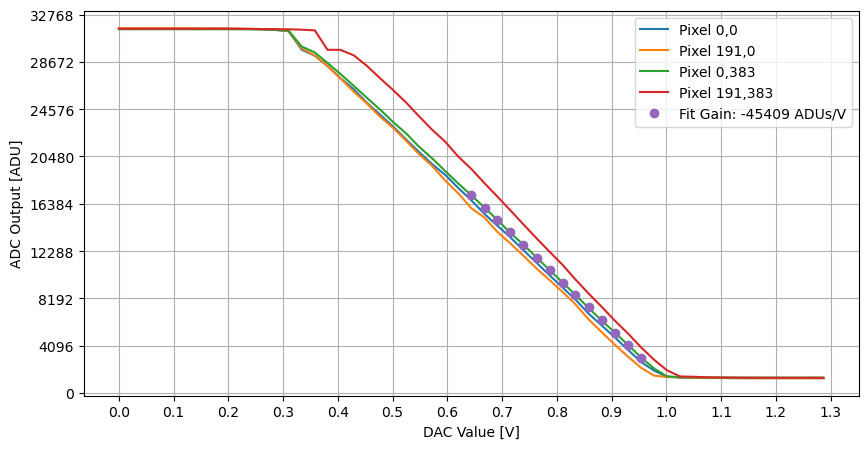

In [22]:
from matplotlib.ticker import MultipleLocator

plt.figure(figsize = (10,5))

plt.plot(DACScan,dataScan[0,0,:], label='Pixel 0,0')
plt.plot(DACScan,dataScan[191,0,:], label='Pixel 191,0')
plt.plot(DACScan,dataScan[0,383,:], label='Pixel 0,383')
plt.plot(DACScan,dataScan[191,383,:], label='Pixel 191,383')

plt.plot(x[start_index:end_index+1], best_linear_range['slope'] * x[start_index:end_index+1] + best_linear_range['intercept'], 'o', label='Fit Gain: {:.0f} ADUs/V'.format(gain))

plt.legend()



ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_major_locator(MultipleLocator(4096))
plt.grid(True)

ax.set_ylabel('ADC Output [ADU]')
ax.set_xlabel('DAC Value [V]')


# Show the plots
plt.show()



# Check Pixel range

In [27]:
# Set threshold to the minimum voltage (maximum energy, should not switch)
ASIC2.CompTH_ePixM.set(0)
ASIC2.mTest.set(False)

# Reference pixel
ref_row = 100
ref_col = 150

# Optimal bias settings
ASIC2.RefinN.set(6)
ASIC2.RefinP.set(1)

ASIC2.RefinN.set(6)
ASIC2.RefinP.set(0)


plt.figure(figsize = (10,5))


# Get ramps and calculate gain
ChInjValues, PixOutValues = ChInjRamp(DEBUG2, numberOfTriggers=3,Min=0,Max=400,numSteps=10)



Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)


<Figure size 1000x500 with 0 Axes>

Noise:-0.0006606595706740383


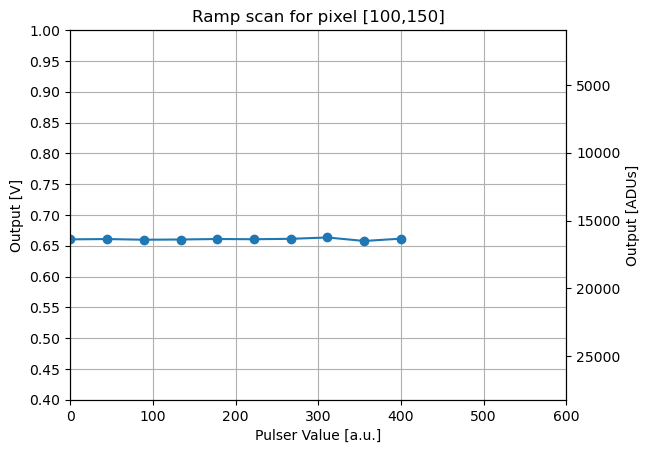

In [28]:
plt.plot(ChInjValues, 1*((PixOutValues-offset))/gain,'o-', label='{}/{}')
plt.xlim(0, 600)  # Set x axis limits from 2 to 8
plt.ylim(0.4, 1.0)  # Set y axis limits from -1 to 1

plt.ylabel("Output [V]")
plt.xlabel("Pulser Value [a.u.]")

ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(100))
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax2 = ax.twinx()
ax2.plot(ChInjValues, -1*PixOutValues)

plt.xlim(0, 600)  # Set x axis limits from 2 to 8
plt.ylim((0.4*gain+offset), (1.0*gain+offset))  # Set y axis limits from -1 to 1

plt.ylabel("Output [ADUs]")




plt.title('Ramp scan for pixel [{},{}]'.format(ref_row,ref_col))
ax.grid(True)

print('Noise:{}'.format(30/gain))

RefinP = 0
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
RefinP = 1
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
RefinP = 2
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
RefinP = 3
Data Descrambled
(192, 384

KeyboardInterrupt: 

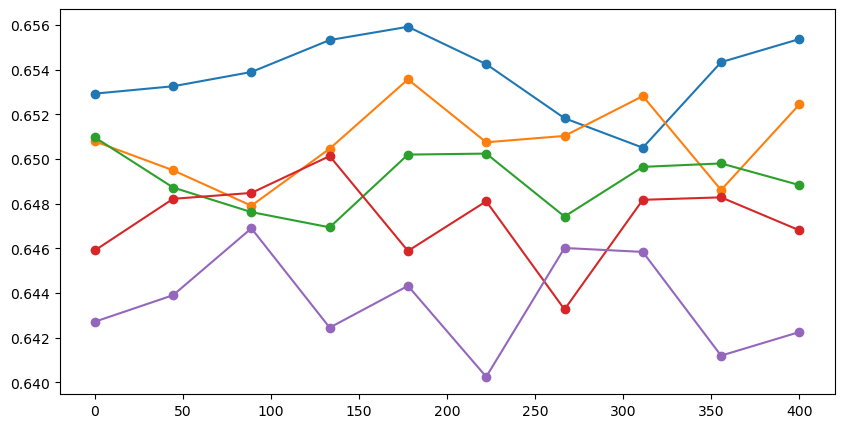

In [30]:
# Set threshold to the minimum voltage (maximum energy, should not switch)
ASIC2.CompTH_ePixM.set(0)
ASIC2.mTest.set(False)

# Reference pixel
ref_row = 100
ref_col = 150

# Optimal bias settings
ASIC2.RefinN.set(6)
ASIC2.RefinP.set(1)

plt.figure(figsize = (10,5))

for RefinPValue in range(7):
    print('RefinP = {}'.format(RefinPValue))
    ASIC3.RefinP.set(RefinPValue)
    # Get ramps and calculate gain
    ChInjValues, PixOutValues = ChInjRamp(DEBUG2, numberOfTriggers=3,Min=0,Max=400,numSteps=10)
    plt.plot(ChInjValues, 1*((PixOutValues-offset))/gain,'o-', label='RefinP = {}'.format(RefinPValue))

plt.ylabel("Output [V]")
plt.xlabel("Pulser Value [a.u.]")
ax = plt.gca()
ax.grid(True)

plt.legend()


In [31]:
setR0(200, 200)
setAcq1(200, 400)
setSR0(40000, 1200)

# 100 = 0.64 uS

print(f'R0 Width set to {REGCTRL.R0Width_us.get():.3f}uS')
print(f'R0 Delay set to {REGCTRL.R0Delay_us.get():.3f}uS') 
print(f'Acq1 Width set to {REGCTRL.AcqWidth1_us.get():.3f}uS')
print(f'Acq1 Delay set to {REGCTRL.AcqDelay1_us.get():.3f}uS')
print(f'SR0 Width set to {REGCTRL.SR0Width1_us.get():.3f}uS')
print(f'SR0 Delay set to {REGCTRL.SR0Delay_us.get():.3f}uS')
print(f'-------------------------')
baseline_int_time = REGCTRL.AcqDelay1_us.get() - REGCTRL.R0Delay_us.get()
integration_time = REGCTRL.AcqWidth1_us.get()
print(f'Baseline time:    {baseline_int_time} uS')
print(f'Integration time: {integration_time} uS')
print(f'Sampling done at: {REGCTRL.AcqWidth1_us.get()+REGCTRL.AcqDelay1_us.get()} uS')
print(f'-------------------------')

R0 Width set to 1.280uS
R0 Delay set to 1.280uS
Acq1 Width set to 1.280uS
Acq1 Delay set to 2.560uS
SR0 Width set to 238.095uS
SR0 Delay set to 7.143uS
R0 Width set to 1.280uS
R0 Delay set to 1.280uS
Acq1 Width set to 1.280uS
Acq1 Delay set to 2.560uS
SR0 Width set to 238.095uS
SR0 Delay set to 7.143uS
-------------------------
Baseline time:    1.28 uS
Integration time: 1.28 uS
Sampling done at: 3.84 uS
-------------------------


In [ ]:
# Set some registers...
ASIC2.CompTH_ePixM.set(0)



# Reference pixel
ref_row = 100
ref_col = 150

# Optimal bias settings
ASIC2.RefinN.set(6)
ASIC2.RefinP.set(2)

# Define integration time values
intTimeValues = [100,120,140,160,180,200,240,280,320,400,560]

# Define empty arrays
noise   = np.empty(np.shape(intTimeValues)[0])
gain    = np.empty(np.shape(intTimeValues)[0])
intTimeValues_us = np.empty(np.shape(intTimeValues)[0])

setSR0(40000, 2000)

for i,intTime in enumerate(intTimeValues):
    print(f'--- Acquiring data value {intTime} ---')
    print(f'-------------------------')
    setR0(100+intTime*2, 200)
    setAcq1(intTime, intTime+200)
    baseline_int_time = REGCTRL.AcqDelay1_us.get() - REGCTRL.R0Delay_us.get()
    integration_time = REGCTRL.AcqWidth1_us.get()
    print(f'Baseline time:    {baseline_int_time} uS')
    print(f'Integration time: {integration_time} uS')
    print(f'-------------------------')

    
    # Get ramps and calculate gain
    ChInjValues, pixelRamp = ChInjRamp(DEBUG2, numberOfTriggers=3,Min=150,Max=200,numSteps=4)
    gain[i] = np.polyfit(ChInjValues, pixelRamp, 1)[0]
    
    # Get darks and calculate noise
    data = readoutFrames(DEBUG2 ,100)
    data_noisemap = np.std(data, axis=2)    
    noise[i] = np.median(data_noisemap)
    intTimeValues_us[i] = REGCTRL.AcqWidth1_us.get()
    



print(noise)
print(gain)
print(intTimeValues_us)


SR0 Width set to 238.095uS
SR0 Delay set to 11.905uS
--- Acquiring data value 100 ---
-------------------------
R0 Width set to 1.920uS
R0 Delay set to 1.280uS
Acq1 Width set to 0.640uS
Acq1 Delay set to 1.920uS
Baseline time:    0.6399999999999999 uS
Integration time: 0.64 uS
-------------------------


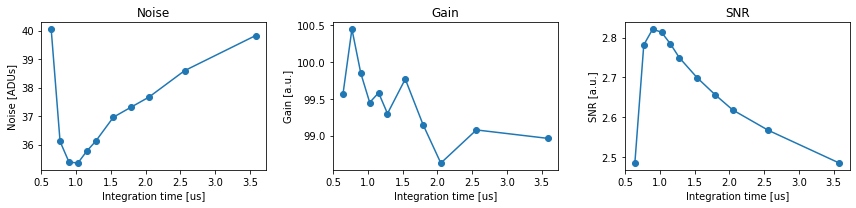

In [100]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))


snr = abs(gain)/noise
axes[0].plot(intTimeValues_us,noise, 'o-')
axes[1].plot(intTimeValues_us,abs(gain), 'o-')
axes[2].plot(intTimeValues_us,snr, 'o-')

# Set titles for each subplot
axes[0].set_title('Noise')
axes[1].set_title('Gain')
axes[2].set_title('SNR')

axes[0].set_xlabel('Integration time [us]')
axes[1].set_xlabel('Integration time [us]')
axes[2].set_xlabel('Integration time [us]')

axes[0].set_ylabel('Noise [ADUs]')
axes[1].set_ylabel('Gain [a.u.]')
axes[2].set_ylabel('SNR [a.u.]')

# Optionally, display the axes on each subplot
axes[0].axis('on')
axes[1].axis('on')
axes[2].axis('on')

plt.tight_layout()
plt.show()


In [104]:
# Set some registers...
ASIC2.CompTH_ePixM.set(0)

# Reference pixel
ref_row = 100
ref_col = 150


# Define integration time
setR0(420, 200)
setAcq1(160, 360)

baseline_int_time = REGCTRL.AcqDelay1_us.get() - REGCTRL.R0Delay_us.get()
integration_time = REGCTRL.AcqWidth1_us.get()
print(f'Baseline time:    {baseline_int_time} uS')
print(f'Integration time: {integration_time} uS')
print(f'-------------------------')


# Define empty arrays

noise   = np.empty([8,8])
gain    = np.empty([8,8])

for RefN_val, RefP_val in np.ndindex(8,8):
    print('--- Acquiring data value {}/{} ---'.format(RefN_val,RefP_val))
    ASIC3.RefinN.set(RefN_val)
    ASIC3.RefinP.set(RefP_val)
    # Get ramps and calculate gain
    ChInjValues, pixelRamp = ChInjRamp(DEBUG2, numberOfTriggers=3,Min=150,Max=200,numSteps=4)
    gain[RefN_val,RefP_val] = np.polyfit(ChInjValues, pixelRamp, 1)[0]
    
    # Get darks and calculate noise
    data = readoutFrames(DEBUG2, 100)
    data_noisemap = np.std(data, axis=2)    
    noise[RefN_val,RefP_val] = np.median(data_noisemap)

print(noise)
print(gain)

R0 Width set to 2.688uS
R0 Delay set to 1.280uS
Acq1 Width set to 1.024uS
Acq1 Delay set to 2.304uS
Baseline time:    1.0239999999999998 uS
Integration time: 1.024 uS
-------------------------
--- Acquiring data value 0/0 ---
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 100)
--- Acquiring data value 0/1 ---
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 100)
--- Acquiring data value 0/2 ---
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 100)
--- Acquiring data value 0/3 ---
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 100)
--- Acquiring data value 0/4 ---
Data Descrambl

Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 100)
--- Acquiring data value 5/3 ---
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 100)
--- Acquiring data value 5/4 ---
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 100)
--- Acquiring data value 5/5 ---
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 100)
--- Acquiring data value 5/6 ---
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 100)
--- Acquiring data value 5/7 ---
Data Descrambled
(192, 384, 3)
Data Descrambled
(1

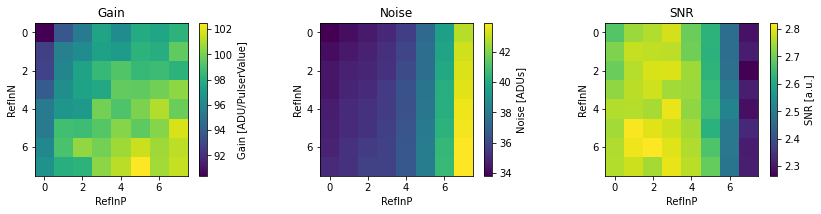

Recommended setting RefN/RefP:(array([6]), array([2]))


In [105]:
snr = abs(gain)/noise

# Create the subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

# Plot the images on each subplot
im1 = axes[0].imshow(abs(gain), cmap='viridis')
im2 = axes[1].imshow(noise, cmap='viridis')
im3 = axes[2].imshow(snr, cmap='viridis')

# Set titles for each subplot
axes[0].set_title('Gain')
axes[1].set_title('Noise')
axes[2].set_title('SNR')

axes[0].set_xlabel('RefInP')
axes[1].set_xlabel('RefInP')
axes[2].set_xlabel('RefInP')

axes[0].set_ylabel('RefInN')
axes[1].set_ylabel('RefInN')
axes[2].set_ylabel('RefInN')

# Optionally, display the axes on each subplot
axes[0].axis('on')
axes[1].axis('on')
axes[2].axis('on')

# Add colorbars to each subplot
cbar1 = fig.colorbar(im1, ax=axes[0])
cbar2 = fig.colorbar(im2, ax=axes[1])
cbar3 = fig.colorbar(im3, ax=axes[2])

# Set colorbar labels (optional)
cbar1.set_label('Gain [ADU/PulserValue]')
cbar2.set_label('Noise [ADUs]')
cbar3.set_label('SNR [a.u.]')

# Show the plots
plt.tight_layout()
plt.show()

print('Recommended setting RefN/RefP:{}'.format(np.where(snr == snr.max())))
